In [27]:
#%pip install wbgapi
import wbgapi as wb
import pandas as pd
import requests
import pandas as pd
from io import StringIO
from datetime import datetime
import math


#%pip install missingno
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'  # o 'Arial', 'Times New Roman', etc.
import seaborn as sns
import missingno as msno       # Para visualización de valores nulos
import scipy.stats as stats    # Para pruebas estadísticas
from matplotlib.patches import Patch

# 📊 Extracción de datos del Banco Mundial usando el API

En este paso se realiza una selección de **15 variables socioeconómicas**, agrupadas por temática:

## Ciencia y tecnología

- `IP.JRN.ARTC.SC`: Artículos en publicaciones científicas y técnicas  
- `SP.POP.SCIE.RD.P6`: Investigadores dedicados a investigación y desarrollo (por cada millón de personas)  
- `GB.XPD.RSDV.GD.ZS`: Gasto en investigación y desarrollo (% del PIB)  
- `SP.POP.TECH.RD.P6`: Técnicos de investigación y desarrollo (por cada millón de personas)  


## Economía y crecimiento

- `NY.GDP.PCAP.CD`: PIB per cápita (US$ a precios actuales)  


## Educación

- `SE.XPD.TOTL.GD.ZS`: Gasto público en educación, total (% del PIB)  
- `SE.PRM.ENRR`: Inscripción escolar, nivel primario (% bruto)  
- `SE.SEC.ENRR`: Inscripción escolar, nivel secundario (% bruto)  
- `SE.TER.ENRR`: Inscripción escolar, nivel terciario (% bruto)  
- `SE.XPD.TOTL.GB.ZS`: Gasto público en educación, total (% del gasto del gobierno)  

## Cambio climático

- `ER.PTD.TOTL.ZS`: Áreas protegidas terrestres y marinas (% del total de la superficie territorial)  
- `AG.LND.FRST.K2`: Área selvática (kilómetros cuadrados)  


## Ambiente

- `AG.SRF.TOTL.K2`: Superficie (kilómetros cuadrados)  


## Sector público

- `GE.EST`: Government Effectiveness (Estimate)  


## Infraestructura

- `IT.NET.USER.ZS`: Individuos que utilizan Internet (% de la población)


In [3]:
wb.source.info()
wb.economy.info(db=75)


# Lista de variables seleccionadas del Banco Mundial
SEvar = ['GB.XPD.RSDV.GD.ZS','IP.JRN.ARTC.SC', 'SP.POP.SCIE.RD.P6', 'SP.POP.TECH.RD.P6', 'NY.GDP.PCAP.CD', 'SE.XPD.TOTL.GD.ZS', 'SE.XPD.TOTL.GB.ZS', 'SE.PRM.ENRR', 'SE.SEC.ENRR','SE.TER.ENRR', 'ER.PTD.TOTL.ZS', 'AG.LND.FRST.K2', 'AG.SRF.TOTL.K2', 'GE.EST' , 'IT.NET.USER.ZS']


# Países participantes en GBIF
GBIF_countries = ['AND', 'AGO', 'ARG', 'ARM', 'AUS', 'BEL', 'BEN', 'BRA', 'BDI', 'KHM', 'CMR', 'CAN', 'CAF',
 'CHL', 'COL', 'CRI', 'HRV', 'DNK', 'ECU', 'EST', 'FIN', 'FRA', 'GEO', 'DEU', 'GTM', 'GIN',
 'ISL', 'IRL', 'LBR', 'LUX', 'MDG', 'MWI', 'MRT', 'MEX', 'MNG', 'NAM', 'NLD', 'NZL', 'NOR',
 'PAN', 'PER', 'POL', 'PRT', 'SLE', 'SVK', 'SVN', 'ZAF', 'SSD', 'ESP', 'SUR', 'SWE', 'CHE',
 'TJK', 'TGO', 'TON', 'GBR', 'USA', 'URY', 'UZB', 'ZWE']

#Carga de datos con el API del Banco Mundial para los países seleccionados. 
#SE_Col_data= wb.data.DataFrame(SEvar, 'COL', time=range(2000, 2025), labels=True).reset_index()
SEdata= wb.data.DataFrame(SEvar, GBIF_countries, time=range(2000, 2025), labels=True).reset_index()

SEdata.head(5)


# Pivotear y organizar la tabla en un formato legible para el análisis.

# Cargar los datos
SEdata = SEdata.drop(columns=['Series'])

# Aplicar la función Melt para convertir los años de columnas a filas
SEdata_long = SEdata.melt(
    id_vars=["economy", "series", "Country"],
    var_name="Year",
    value_name="Value"
)

# Limpiar el campo Year: eliminar 'YR' y convertir a datetime
SEdata_long["Year"] = SEdata_long["Year"].str.replace("YR", "", regex=False)
SEdata_long["Year"] = pd.to_datetime(SEdata_long["Year"], format="%Y")
SEdata_long["Year"] = SEdata_long["Year"].dt.year  # Extrae solo el año como número

#Pivotear usando los valores de 'Series' como nombres de columna
SEdata_pivot = SEdata_long.pivot_table(
    index=["economy", "Country", "Year"],
    columns="series",
    values="Value",
    aggfunc="first"  # por si hay duplicados
).reset_index()

#  limpiar nombre de columnas si queda jerarquía
SEdata_pivot.columns.name = None



#Countries metadata


# URL de la API para obtener información de países
url = "https://api.worldbank.org/v2/country?format=json&per_page=300"

# Realizar la solicitud GET
response = requests.get(url)
data = response.json()

# Extraer los datos de los países
countries = data[1]  # La segunda parte del JSON contiene la lista de países

# Crear un DataFrame con la información relevante
countries_meta = pd.DataFrame([{
    "id": country["id"],
    "iso2Code": country["iso2Code"],
    "region": country["region"]["value"],
    "incomeLevel": country["incomeLevel"]["value"],
    "lendingType": country["lendingType"]["value"],
   
} for country in countries])

# Mostrar las primeras filas del DataFrame
print(countries_meta.head())



BM_Data = pd.merge(SEdata_pivot, countries_meta, left_on="economy", right_on="id", how="left")
##### Transformaciones

BM_Data  = BM_Data.rename(columns={'Year': 'year'})
BM_Data  = BM_Data.rename(columns={'Country': 'country'})
BM_Data  = BM_Data.rename(columns={'iso2Code': 'countryCode'})
dropcolumns = ['economy','id']
BM_Data = BM_Data.drop(dropcolumns, axis=1)






    id iso2Code                      region  incomeLevel     lendingType
0  ABW       AW  Latin America & Caribbean   High income  Not classified
1  AFE       ZH                  Aggregates   Aggregates      Aggregates
2  AFG       AF                  South Asia   Low income             IDA
3  AFR       A9                  Aggregates   Aggregates      Aggregates
4  AFW       ZI                  Aggregates   Aggregates      Aggregates


# Descripción del código: Extracción, limpieza y unión de datos de GBIF

Este segmento del script descarga, filtra y une automáticamente datos de GBIF, centrados en ocurrencias y especies reportadas en el país y por país publicador.
Finalmente une los cuatro DataFrames usando una unión externa (outer join) por year y countryCode para obtener como resultado una tabla integrada con los conteos por país y año, tanto desde el punto de vista del país donde ocurre la observación como del país que publica.

In [4]:


############################################
# Descargar los datos y generar subset por año y país
############################################

# Parámetros
BASE_URL = "https://analytics-files.gbif.org/global/csv/"
GBIF_FILES = [
    "occ_country.csv",
    "occ_publisherCountry.csv",
    "spe_country.csv",
    "spe_publisherCountry.csv"
]
DIAS_UMBRAL = 60  # días alrededor del 31 de diciembre a considerar

# Función para cargar archivos CSV desde URL
def load_csv(filename):
    url = BASE_URL + filename
    try:
        print(f"📥 Cargando {filename} desde: {url}")
        response = requests.get(url)
        response.raise_for_status()
        df = pd.read_csv(StringIO(response.text))
        print(f"✅ {filename} cargado con éxito.")
        return df
    except Exception as e:
        print(f"❌ Error al cargar {filename}: {e}")
        return pd.DataFrame()

# Función para ajustar el año según cercanía a diciembre 31
def ajustar_anio(snapshot, max_dias=DIAS_UMBRAL):
    d31_prev = datetime(snapshot.year - 1, 12, 31)
    d31_curr = datetime(snapshot.year, 12, 31)
    diff_prev = abs((snapshot - d31_prev).days)
    diff_curr = abs((snapshot - d31_curr).days)
    
    if diff_prev <= max_dias and snapshot < d31_curr:
        return snapshot.year - 1
    elif diff_curr <= max_dias:
        return snapshot.year
    else:
        return None

# Función para obtener solo la fecha más cercana a 31 dic por año
def extraer_snapshot_mas_cercano(df, dias_umbral=DIAS_UMBRAL):
    df = df.copy()
    df["snapshot"] = pd.to_datetime(df["snapshot"])
    df["year"] = df["snapshot"].apply(lambda x: ajustar_anio(x, dias_umbral))
    df = df.dropna(subset=["year"])
    
    df["dist_to_d31"] = df.apply(
        lambda row: abs((row["snapshot"] - datetime(int(row["year"]), 12, 31)).days),
        axis=1
    )
    
    df_sorted = df.sort_values(by=["year", "dist_to_d31"])
    fechas_cercanas = df_sorted.groupby("year")["snapshot"].first().reset_index()
    
    df_final = df.merge(fechas_cercanas, on=["year", "snapshot"], how="inner")
    return df_final.drop(columns=["dist_to_d31"])

# Cargar y procesar todos los archivos
dataframes = {}
for filename in GBIF_FILES:
    key = filename.replace(".csv", "")
    df_raw = load_csv(filename)
    if not df_raw.empty:
        dataframes[key] = extraer_snapshot_mas_cercano(df_raw)

globals().update(dataframes)

# Ejemplo: visualizar resultado para 'occ_country'
print(dataframes["occ_country"].head())

########################
#Unión de archivos de datos de GBIF.
########################

# Renombrar columnas
spe_publisherCountry.rename(columns={
    'publisherCountry': 'countryCode',
    'speciesCount': 'speciesCount_publisher'
}, inplace=True)

occ_publisherCountry.rename(columns={
    'publisherCountry': 'countryCode',
    'occurrenceCount': 'occurrenceCount_publisher'
}, inplace=True)

occ_country.rename(columns={'country': 'countryCode'}, inplace=True)
spe_country.rename(columns={'country': 'countryCode'}, inplace=True)

# Lista de datasets
datasets = [spe_country, spe_publisherCountry, occ_country, occ_publisherCountry]

# Limpieza: eliminar snapshot y filtrar NaNs en countryCode
for i in range(len(datasets)):
    datasets[i] = datasets[i].drop(columns=["snapshot"], errors="ignore")
    datasets[i] = datasets[i].dropna(subset=["countryCode"])

# Merge usando year y countryCode como claves
from functools import reduce
df_merged = reduce(lambda left, right: pd.merge(left, right, on=["year", "countryCode"], how="outer"), datasets)

# Mostrar una vista previa
print(df_merged.head())



📥 Cargando occ_country.csv desde: https://analytics-files.gbif.org/global/csv/occ_country.csv
✅ occ_country.csv cargado con éxito.
📥 Cargando occ_publisherCountry.csv desde: https://analytics-files.gbif.org/global/csv/occ_publisherCountry.csv
✅ occ_publisherCountry.csv cargado con éxito.
📥 Cargando spe_country.csv desde: https://analytics-files.gbif.org/global/csv/spe_country.csv
✅ spe_country.csv cargado con éxito.
📥 Cargando spe_publisherCountry.csv desde: https://analytics-files.gbif.org/global/csv/spe_publisherCountry.csv
✅ spe_publisherCountry.csv cargado con éxito.
    snapshot country  occurrenceCount    year
0 2007-12-19     NaN          6052780  2007.0
1 2007-12-19      AD            13343  2007.0
2 2007-12-19      AE             1192  2007.0
3 2007-12-19      AF            23395  2007.0
4 2007-12-19      AG             3286  2007.0
  countryCode  speciesCount    year  speciesCount_publisher  occurrenceCount  \
0          AD       10037.0  2007.0                     NaN       

### Unión de datos socieconómicos y de publicación de biodiversidad

In [5]:
Data = pd.merge(BM_Data, df_merged, on=["year", "countryCode"], how="left")

# Análisis Exploratorio de Datos

In [10]:
EDA_basic = pd.concat([
        Data.describe(include='all').T,
        Data.isnull().sum().rename("Missing"),
        Data.dtypes.rename("Type")
    ], axis=1)

EDA_basic

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,Missing,Type
country,1500,60,Angola,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,object
year,1500.0,NaN,NaN,NaN,2012.0,7.213507,2000.0,2006.0,2012.0,2018.0,2024.0,0,int64
AG.LND.FRST.K2,1368.0,NaN,NaN,NaN,330847.503669,879032.556909,89.5,12689.485,66399.5,176825.2,5510886.0,132,float64
AG.SRF.TOTL.K2,1368.0,NaN,NaN,NaN,1083790.80916,2684184.374487,470.0,69700.0,243610.0,624499.25,15640500.0,132,float64
ER.PTD.TOTL.ZS,720.0,NaN,NaN,NaN,17.643427,11.667154,0.1,7.6,17.3,24.3,55.8,780,float64
GB.XPD.RSDV.GD.ZS,879.0,NaN,NaN,NaN,1.233292,1.007517,0.01019,0.300665,1.05575,1.984525,3.8738,621,float64
GE.EST,1367.0,NaN,NaN,NaN,0.305873,1.145597,-2.440221,-0.69666,0.218387,1.497468,2.347191,133,float64
IP.JRN.ARTC.SC,1380.0,NaN,NaN,NaN,17877.977239,55542.095638,0.0,65.265,677.445,11458.42,472448.44,120,float64
IT.NET.USER.ZS,1408.0,NaN,NaN,NaN,46.149278,34.235665,0.0177,10.0,46.25,80.0,99.8,92,float64
NY.GDP.PCAP.CD,1423.0,NaN,NaN,NaN,20445.934153,25095.830341,111.406683,1664.649436,7949.888672,37213.020916,133711.794436,77,float64


Gráfico de celdas vacías

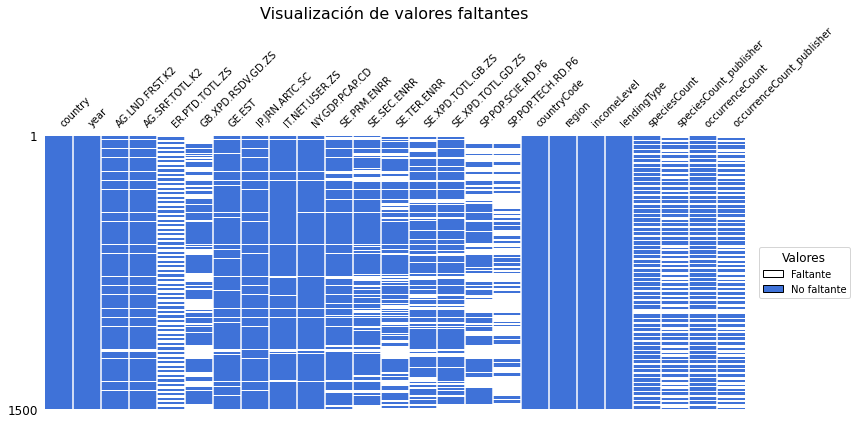

In [7]:
# Crear el gráfico
fig, ax = plt.subplots(figsize=(12, 6))
msno.matrix(Data, 
            ax=ax,
            color=(0.25, 0.45, 0.85), 
            sparkline=False,
            fontsize=10)

# Crear leyenda personalizada
legend_elements = [
    Patch(facecolor='white', edgecolor='black', label='Faltante'),
    Patch(facecolor=(0.25, 0.45, 0.85), edgecolor='black', label='No faltante')
]

# Añadir leyenda fuera del gráfico
ax.legend(
    handles=legend_elements,
    loc='center left',             # Ubicación relativa
    bbox_to_anchor=(1.02, 0.5),    # Fuera a la derecha, centrada verticalmente
    borderaxespad=0,
    title='Valores',
    fontsize=10,
    title_fontsize=12
)

# Título del gráfico
ax.set_title('Visualización de valores faltantes', fontsize=16)

# Ajustar layout para que no se corte la leyenda
plt.tight_layout()
plt.show()

A través del análisis de datos faltantes se observa que hay una alta cantidad de datos faltantes en las variables seleccionadas, incluso dentro delas variables objetivo occurrenceCount y occurrenceCount_publisher. Esto se debe principalmente a la fecha en la que cada país ingreso a la red de GBIF o iniciaron con la publicación de datos a través de esta red.

En general hay 1,405 filas con almenos un dato faltante, lo que equivale a un 93.7% de las filas del dataset.

In [ ]:
#Selección de variables para el análisis basado en las variables numéricas del Banco Mundial
var_BM = [
    'AG.SRF.TOTL.K2',
    'AG.LND.FRST.K2',
    'ER.PTD.TOTL.ZS',
    'GB.XPD.RSDV.GD.ZS',
    'GE.EST',
    'IP.JRN.ARTC.SC',
    'IT.NET.USER.ZS',
    'NY.GDP.PCAP.CD',
    'SE.PRM.ENRR',
    'SE.SEC.ENRR',
    'SE.TER.ENRR',
    'SE.XPD.TOTL.GB.ZS',
    'SE.XPD.TOTL.GD.ZS',
    'SP.POP.SCIE.RD.P6',
    'SP.POP.TECH.RD.P6'
]
var_BM_se = Data[var_BM]

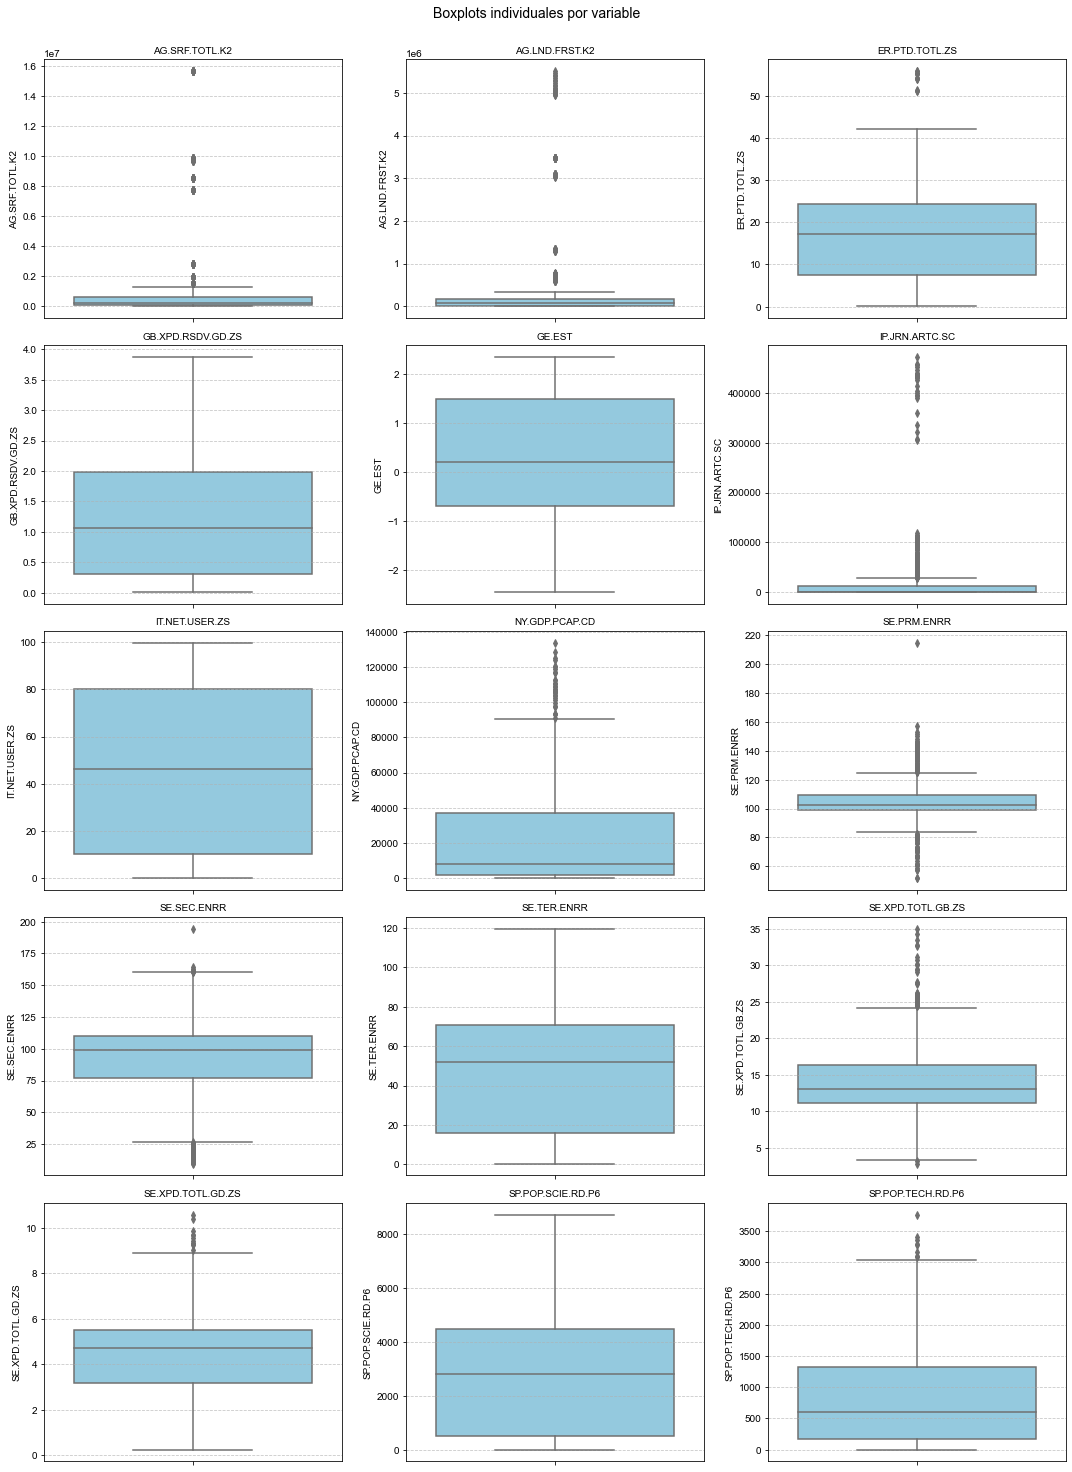

In [42]:
# Número de variables
num_vars = var_BM_se.shape[1]
cols = 3  # Número de columnas en el mosaico
rows = math.ceil(num_vars / cols)

# Crear subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

# Crear un boxplot por variable
for i, col in enumerate(var_BM_se.columns):
    sns.boxplot(data=var_BM_se, y=col, ax=axes[i], color='skyblue')
    axes[i].set_title(col, fontsize=10)
    axes[i].set_xlabel('')
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Eliminar subplots vacíos si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Boxplots individuales por variable", fontsize=14, y=1.02)
plt.show()


Dentro de las variables socioeconómicas las variables AG.LND.FRST.K2 (Área selvática (kilómetros cuadrados)) y AG.SRF.TOTL.K2 (Superficie (kilómetros cuadrados)) presentan la mayor cantidad de valores atípicos reflejando la diversidad de países áreas y extensió de sus áreas selváticas. Esto se cosidera normal y no representa un error que requiera de posteriores ajustes. Sin embargo, estas mismas variables presentan datos vacíos (132 fillas) que se podrían considerar más adelante durante la etapa de transformación.

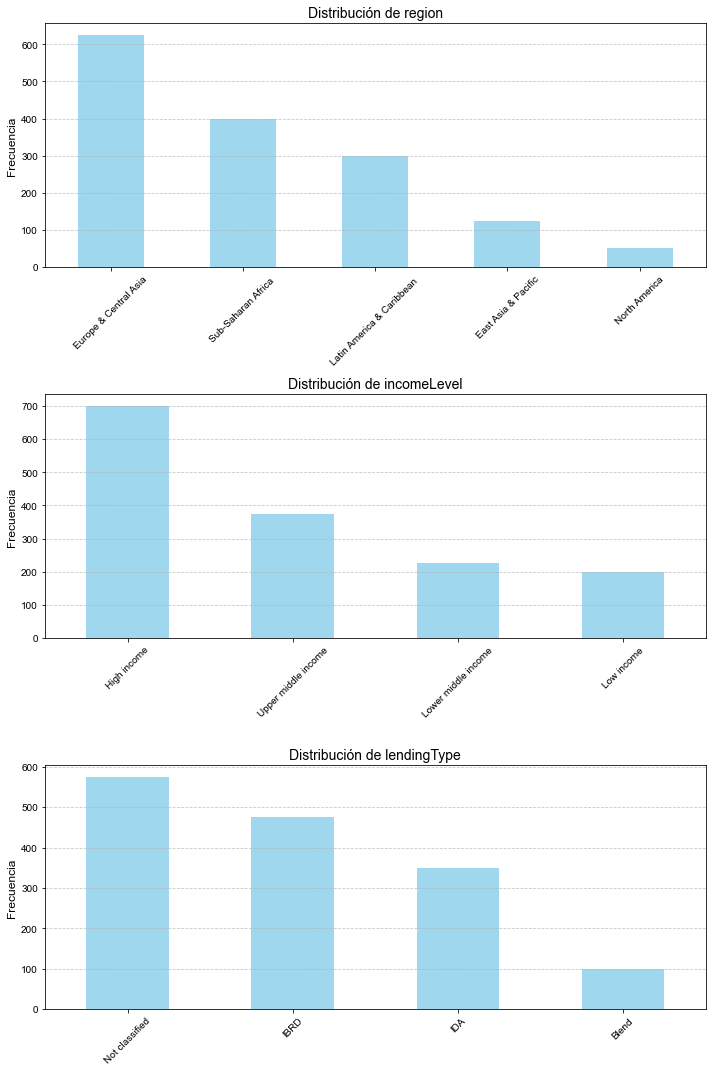

In [43]:

# Variables categóricas a graficar
var_cat_BM = ['region', 'incomeLevel', 'lendingType']
cat_vars = Data[var_cat_BM]

# Crear subplots (uno por variable categórica)
fig, axes = plt.subplots(len(cat_vars.columns), 1, figsize=(10, 5 * len(cat_vars.columns)))

# Asegurar que axes siempre sea iterable
if len(cat_vars.columns) == 1:
    axes = [axes]

# Graficar cada variable
for ax, col in zip(axes, cat_vars.columns):
    counts = Data[col].value_counts(dropna=False)
    counts.plot(kind='bar', ax=ax, color='skyblue', alpha=0.8)

    ax.set_title(f'Distribución de {col}', fontsize=14)
    ax.set_ylabel('Frecuencia', fontsize=12)
    ax.set_xlabel('')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.tick_params(axis='x', rotation=45)  # Rotar etiquetas si son largas

plt.tight_layout()
plt.show()